In [1]:
import tensorflow as tf
import os
import hickle as hkl
import numpy as np

In [2]:

%run ../src/preprocessing/indices.py

In [10]:
predict_model_path = "../models/small-may-41/"

In [11]:
predict_graph_def = tf.compat.v1.GraphDef()
if os.path.exists(predict_model_path):
    print(f"Loading model from {predict_model_path}")
    predict_file = tf.io.gfile.GFile(predict_model_path + "predict_graph.pb", 'rb')
    predict_graph_def.ParseFromString(predict_file.read())
    predict_graph = tf.import_graph_def(predict_graph_def, name='predict')
    predict_sess = tf.compat.v1.Session(graph=predict_graph)
    predict_logits = predict_sess.graph.get_tensor_by_name(f"predict/conv2d_13/Sigmoid:0") 
    #feature_extraction = predict_sess.graph.get_tensor_by_name(f"predict/csse_out_mul/mul:0")  
    #feature_extraction_initial = predict_sess.graph.get_tensor_by_name(
    #    "predict/conv_median_drop/drop_block2d_1/cond/Merge:0")
    predict_inp = predict_sess.graph.get_tensor_by_name("predict/Placeholder:0")
    predict_length = predict_sess.graph.get_tensor_by_name("predict/PlaceholderWithDefault:0")
else:
    raise Exception(f"The model path {predict_model_path} does not exist")

Loading model from ../models/small-may-41/


In [12]:
min_all = [0.006576638437476157, 0.0162050812542916, 0.010040436408026246, 0.013351644159609368, 
           0.01965362020294499, 0.014229037918669413, 0.015289539940489814, 0.011993591210803388, 
           0.008239871824216068, 0.006546120393682765, 0.0, 0.0, 0.0, -0.1409399364817101,
           -0.4973397113668104, -0.09731556326714398, -0.7193834232943873]

max_all = [0.2691233691920348, 0.3740291447318227, 0.5171435111009385, 0.6027466239414053, 
           0.5650263218127718, 0.5747005416952773, 0.5933928435187305, 0.6034943160143434,
           0.7472037842374304, 0.7000076295109483, 0.509269855802243, 0.948334642387533, 
           0.6729257769285485, 0.8177635298774327, 0.35768999002433816, 0.7545951919107605, 0.7602693339366691]

In [13]:

def convert_to_db(x: np.ndarray, min_db: int) -> np.ndarray:
    """ Converts unitless backscatter coefficient
        to db with a min_db lower threshold
        
        Parameters:
         x (np.ndarray): unitless backscatter (T, X, Y, B) array
         min_db (int): integer from -50 to 0
    
        Returns:
         x (np.ndarray): db backscatter (T, X, Y, B) array
    """
    
    x = 10 * np.log10(x + 1/65535)
    x[x < -min_db] = -min_db
    x = (x + min_db) / min_db
    return np.clip(x, 0, 1)

In [14]:
import pandas as pd
x = hkl.load("../data/train/train_x.hkl")
test_y = hkl.load("../data/train/train_y.hkl")
df = pd.read_csv("../data/train/train_plot_ids.csv")
x = np.delete(x, 11, -1)
x.shape

(2728, 12, 28, 28, 13)

In [15]:
x = np.float32(x) / 65535

x[..., -1] = convert_to_db(x[..., -1], 22)
x[..., -2] = convert_to_db(x[..., -2], 22)

indices = np.empty((x.shape[0], 12, 28, 28, 4))
indices[..., 0] = evi(x)
indices[..., 1] = bi(x)
indices[..., 2] = msavi2(x)
indices[..., 3] = grndvi(x)

x = np.concatenate([x, indices], axis = -1)

In [16]:
idx = 0
pd.set_option('display.float_format', lambda x: '%.5f' % x)

def preprocess_sample(test, idx):

    med = np.median(test[idx], axis = 0)
    med = med[np.newaxis, :, :, :]
    sample = np.concatenate([test[idx], med], axis = 0)
    
    for band in range(0, sample.shape[-1]):
        mins = min_all[band]
        maxs = max_all[band]
        sample[..., band] = np.clip(sample[..., band], mins, maxs)
        midrange = (maxs + mins) / 2
        rng = maxs - mins
        standardized = (sample[..., band] - midrange) / (rng / 2)
        sample[..., band] = standardized
    return sample


In [ ]:
# remove [6, ]

In [18]:
idx = 0

6 14.327572359725632 43.32002790000002


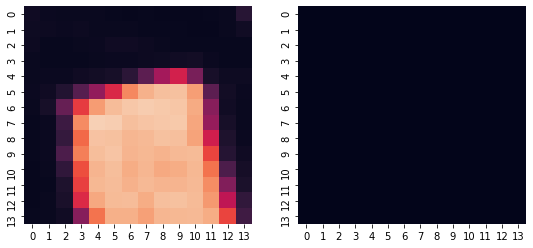

55 -15.69026849970206 124.77258370000008


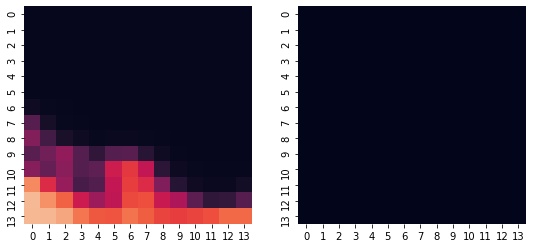

88 -0.2268497149954801 111.97069969999993


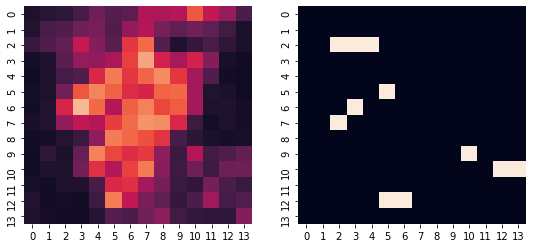

93 -45.51563066942793 168.93846739999972


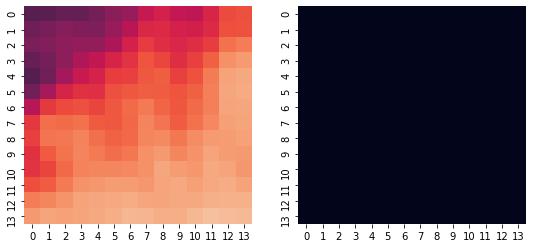

139 16.335699159999987 43.802460939999925


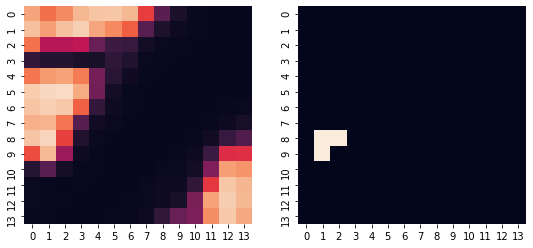

217 3.562615431929034 42.28997737999993


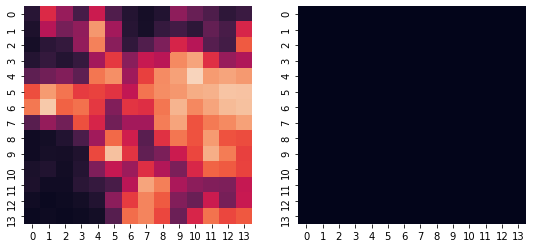

219 6.770380747866025 43.33199031999991


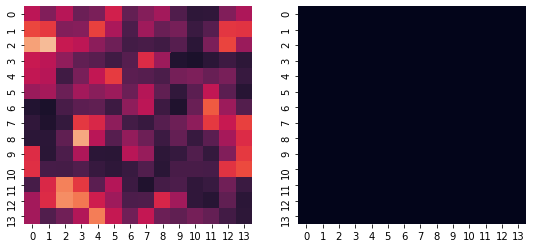

220 6.852107252864456 44.9460887900001


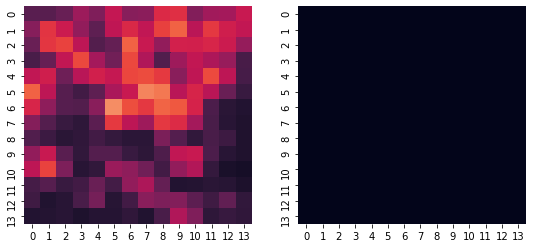

221 7.689803927848254 44.49659300999981


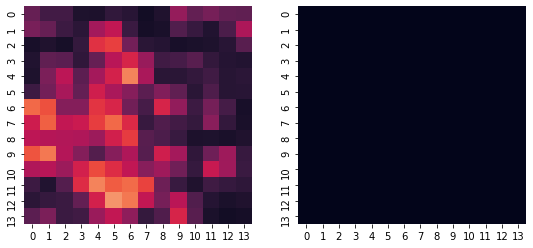

263 26.338299059544987 86.06751368999996


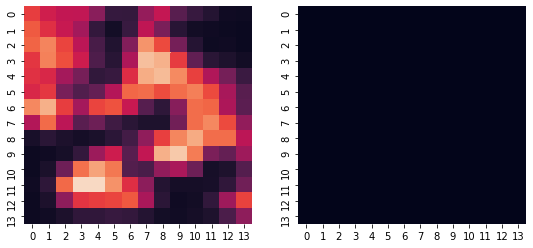

277 18.593702779654137 78.39738468000034


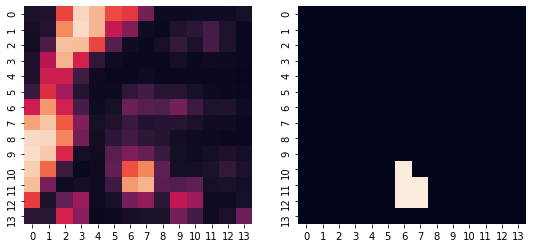

302 -0.1507748249969925 116.6873428000002


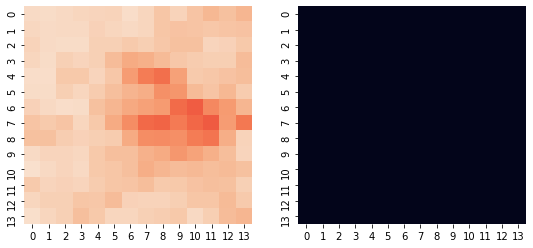

368 -38.88333748944082 174.96934649999983


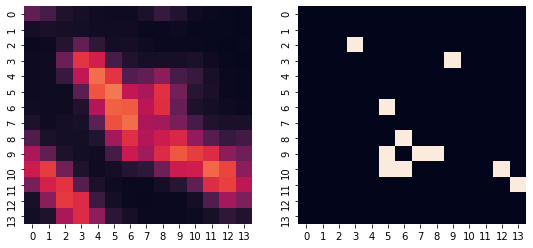

383 -37.74821370944601 176.36642199999983


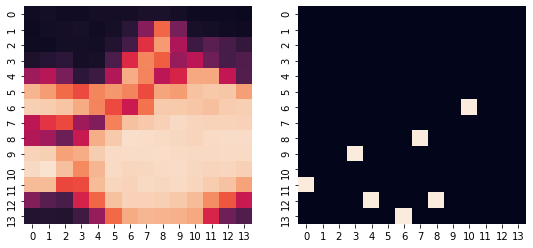

393 -42.87082358942943 171.24381209999984


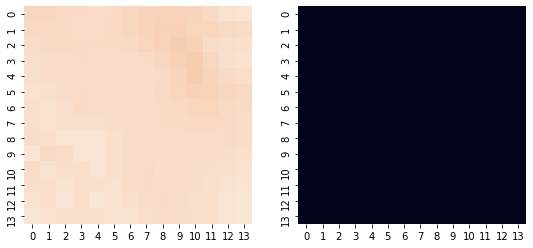

400 -45.956031809428175 167.22722020000003


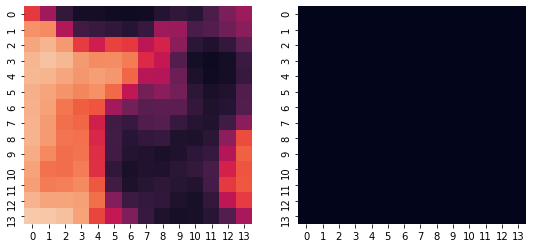

436 24.20214369957211 107.66765770000012


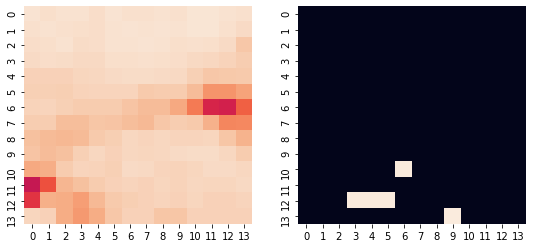

437 24.355170329570072 110.80470360000008


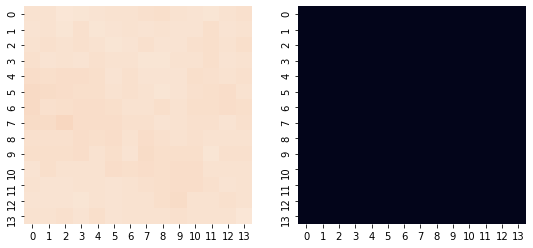

438 24.20214369957211 112.79404980000008


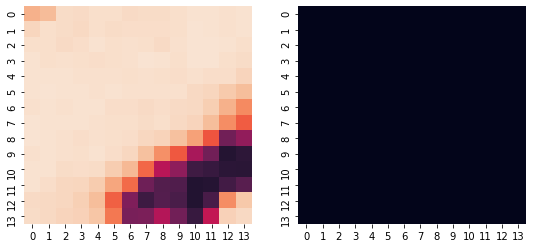

459 7.490247076852108 43.38506734000001


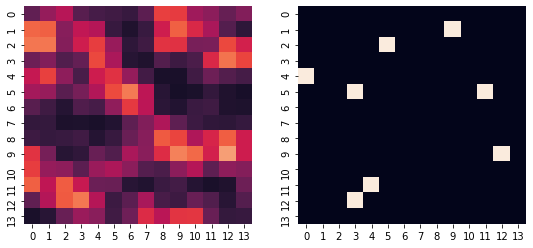

461 7.490247076852108 42.03655162999984


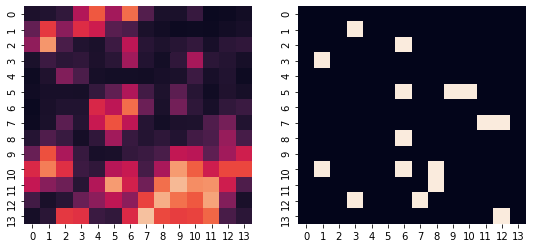

464 4.889538215902809 41.45861632999998


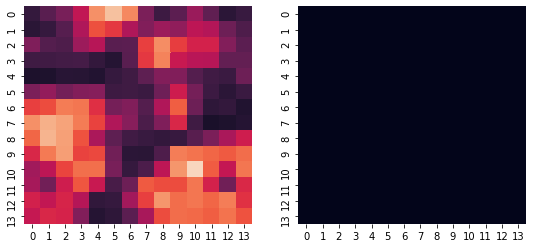

469 4.696893115906607 43.57771244000004


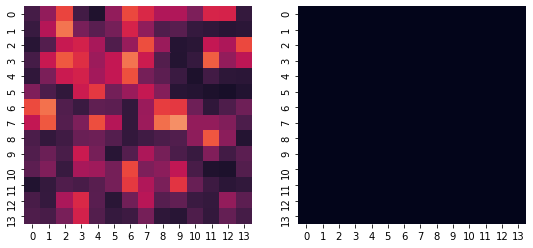

470 4.985860766900911 44.733583039999765


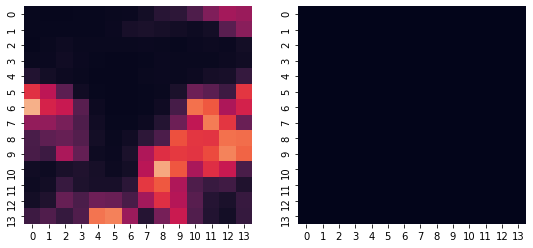

477 6.430699022872638 40.68803593000005


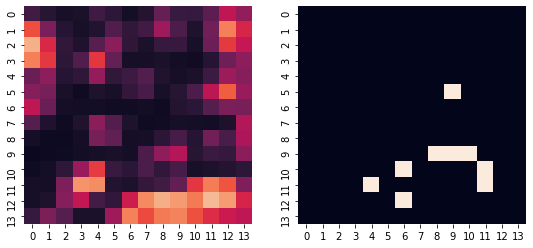

669 -10.743578299790412 123.1379764999998


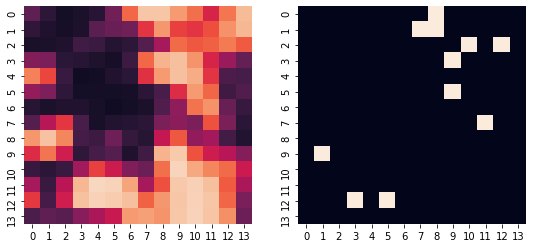

673 -11.485417159776716 131.24340340000003


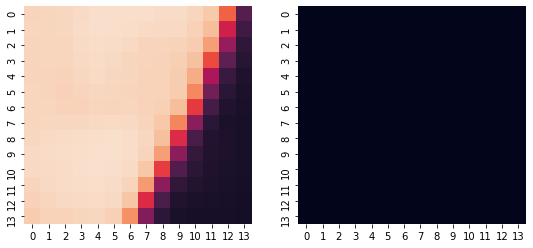

702 -1.881920367962436 126.06501890000008


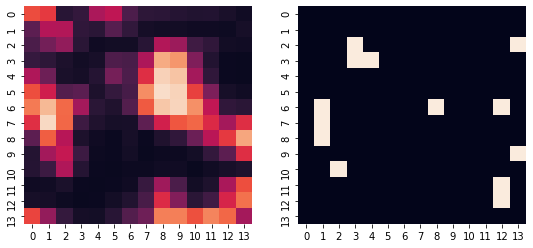

704 10.91941856978717 107.9852201999997


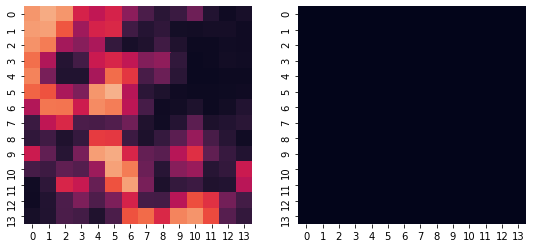

706 11.152872459782836 108.37431000000032


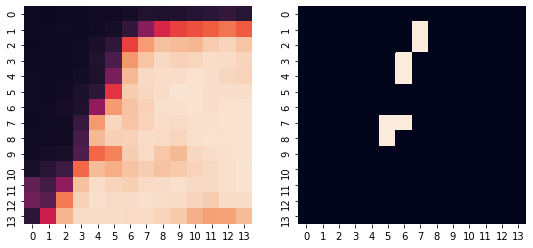

717 37.094174749449465 122.07649520000024


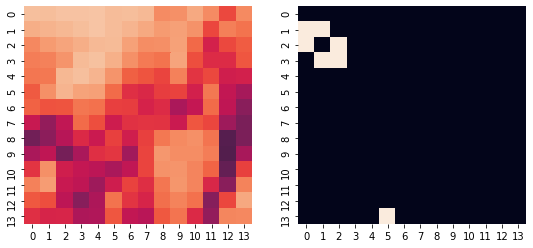

726 35.61248931945825 106.14837689999982


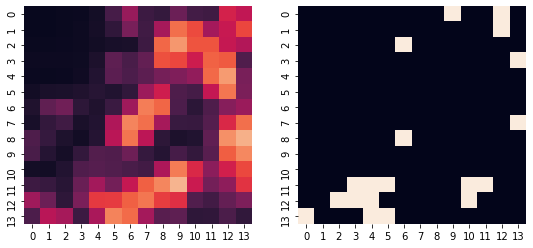

754 38.82280773944107 114.66806810000011


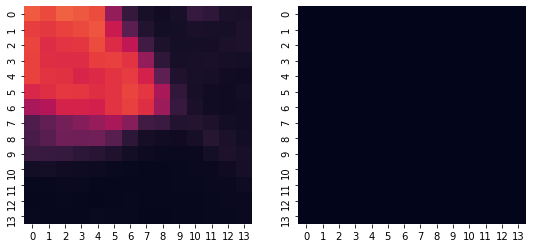

776 1.1500673389770215 41.89671825999992


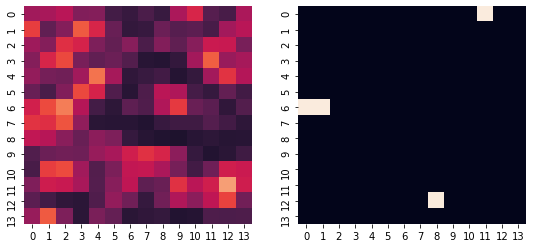

830 41.1109512092856 44.86066015999995


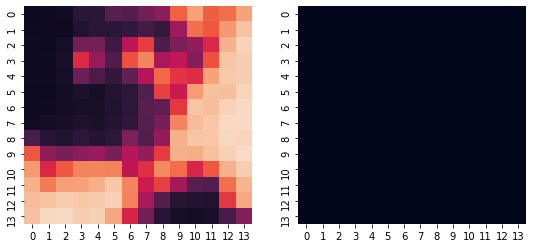

899 9.222175893818983 48.23558061000003


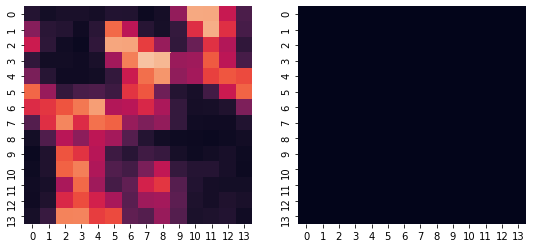

904 5.033692519899983 45.08911016999996


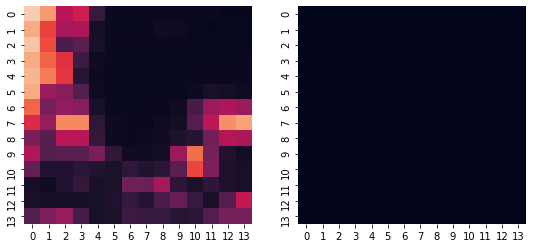

906 4.665923247907225 44.19011862000004


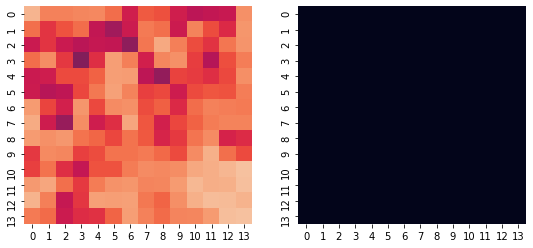

907 4.768081378905213 43.57716983000016


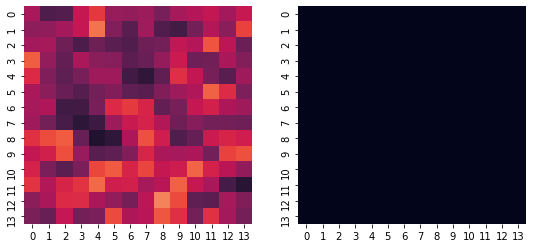

912 3.3174359179338984 40.308109640000026


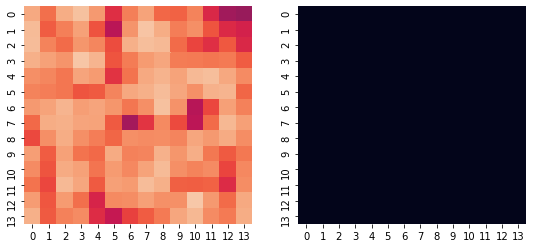

915 3.256141038935113 42.6373150199999


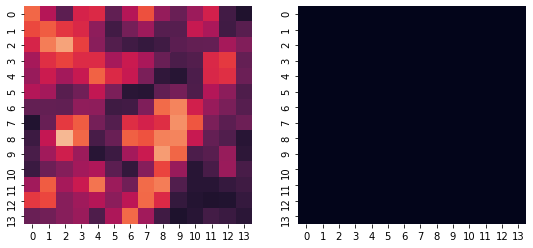

933 3.787363320924565 43.69975959


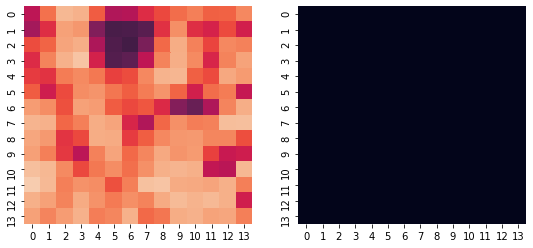

935 4.088506718918628 44.1284405


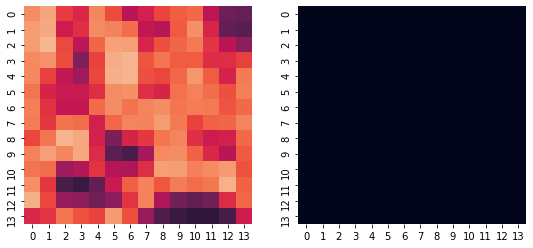

948 0.4761425379904968 41.089778669999895


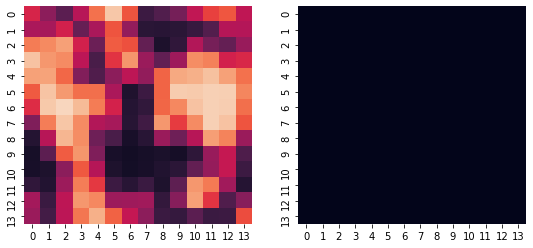

950 1.4336602669713645 41.37084108999987


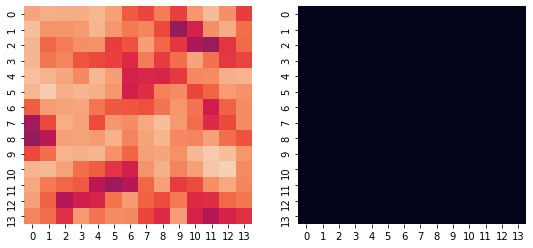

951 4.413455826912191 40.93808600000003


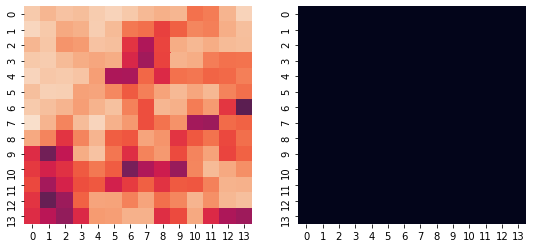

952 4.362858722913215 40.58390626999996


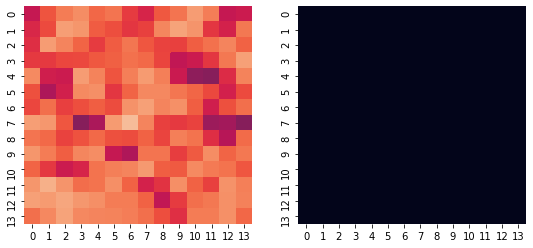

996 22.692613939592697 105.25436220000005


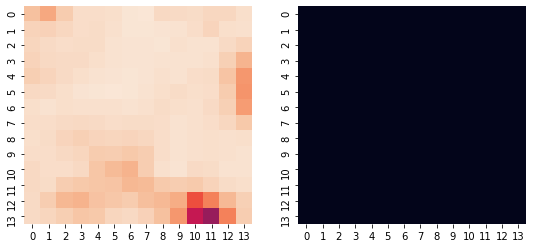

1051 -3.577941195928729 105.29178460000024


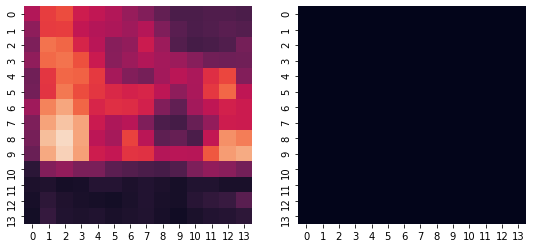

1198 26.95662299953761 114.0182627999998


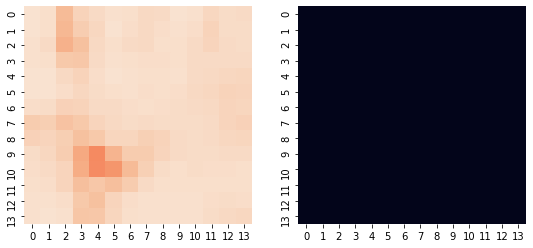

1288 11.092169229783948 18.390101689999995


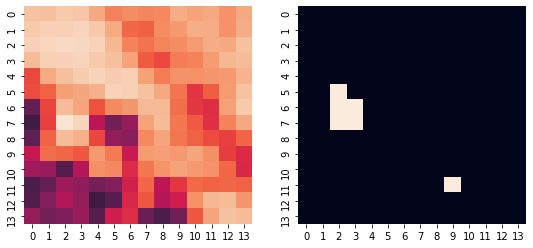

1374 -3.526346771929733 126.98524039999975


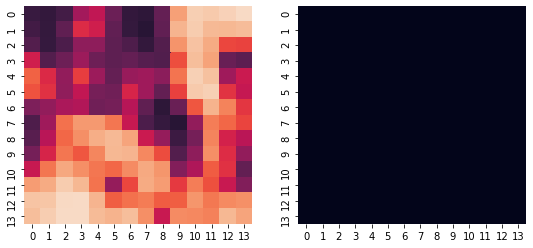

1381 -8.184206019838763 138.29718429999988


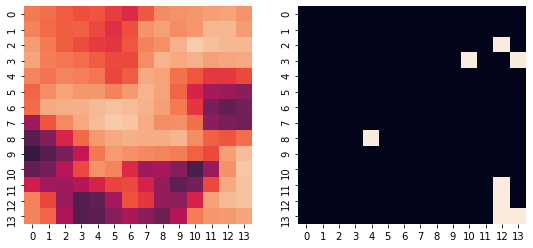

1387 -1.0620984769788018 131.54731939999994


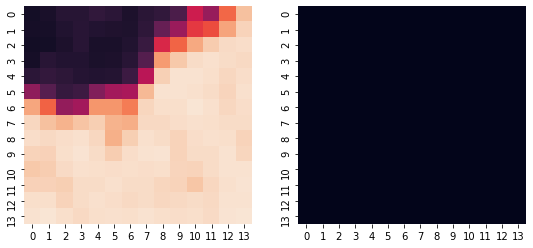

1388 -1.0565927539789044 131.56873059999998


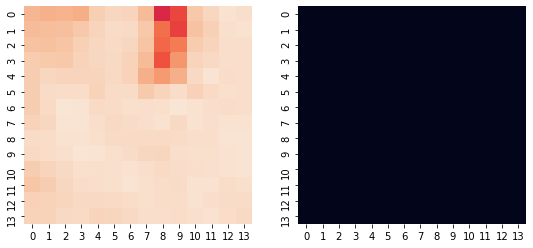

1419 23.83871926957693 77.34962575


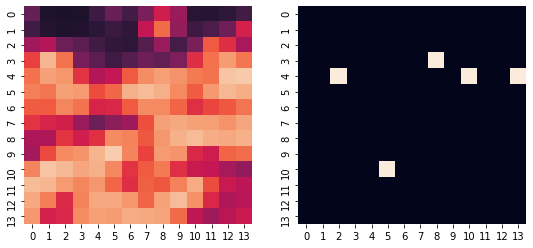

1455 16.06034696969574 94.85096342000035


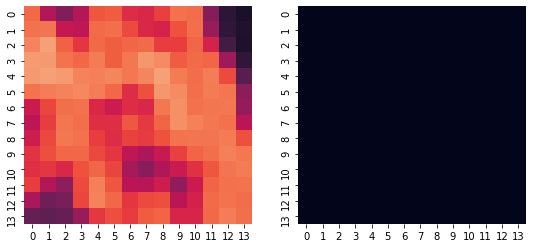

1461 19.198213069644652 97.19331415999974


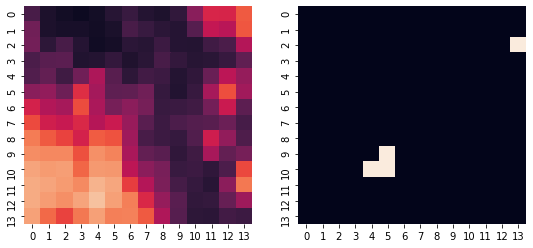

1475 13.364433849742651 101.7454298


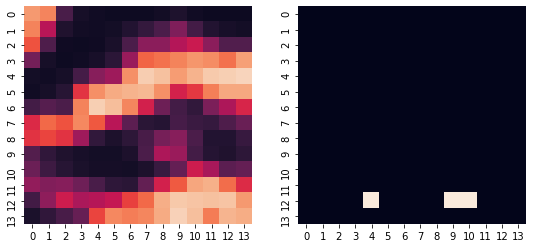

1493 21.966492719603 110.88270959999988


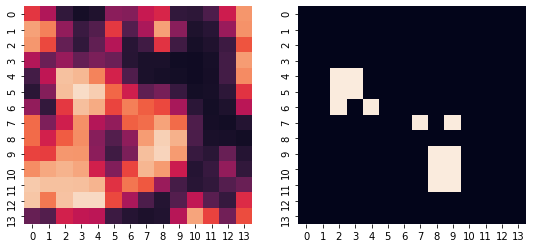

1531 29.324144189511397 120.57529340000008


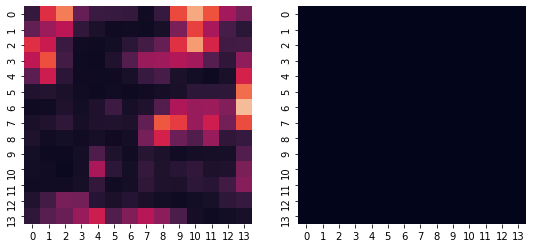

1536 31.758230419487823 117.53268560000032


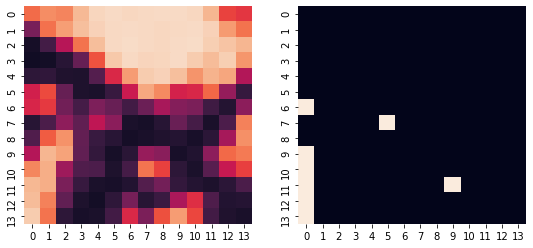

1539 30.106529049503408 111.23014090000032


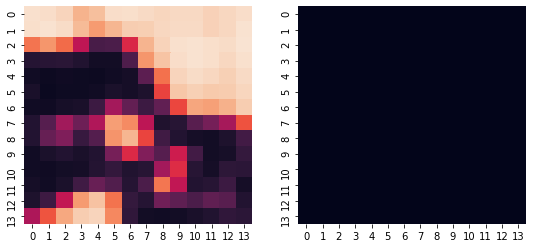

1546 23.796847629577535 88.44957071000002


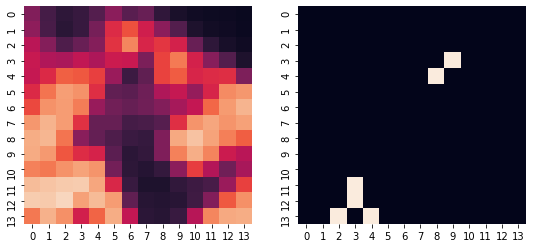

1598 8.372649225835147 124.99346920000006


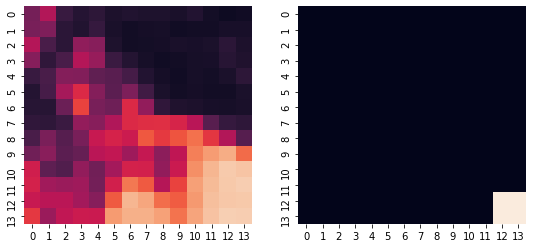

1603 12.210368279763442 124.67980949999983


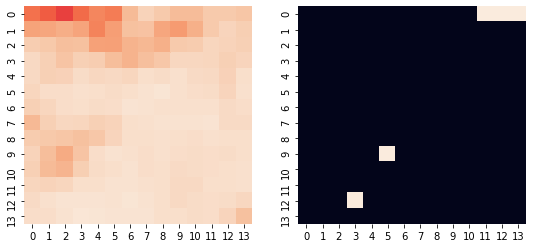

1630 29.721804229507296 113.61194889999994


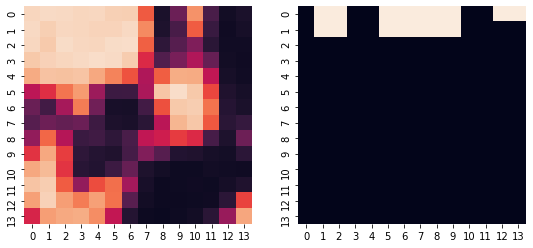

1660 12.595103809756468 78.17521575000009


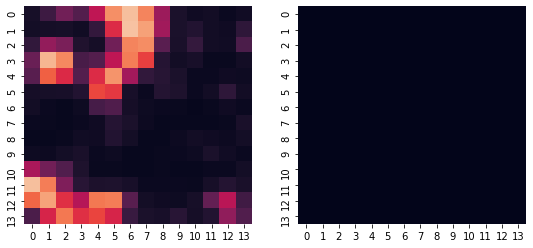

1679 22.36151060959736 70.95839597999995


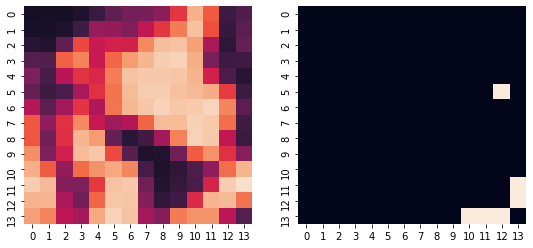

1693 26.70610814954061 105.12406610000006


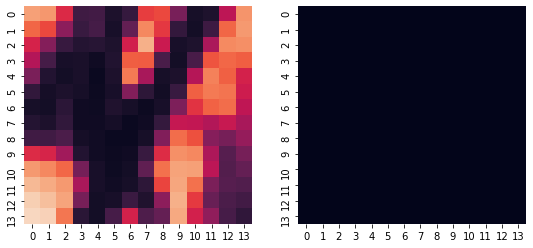

1712 3.4686578349309043 44.03522406000007


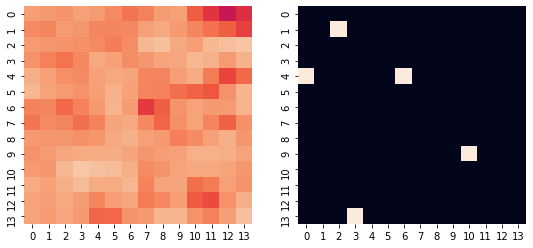

1713 4.346570740913513 43.87764994999998


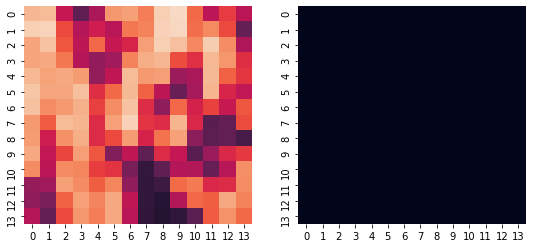

1714 5.224483646896228 43.63003348999985


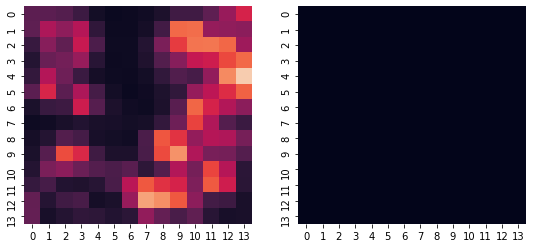

1727 9.97421757280481 47.63691802999983


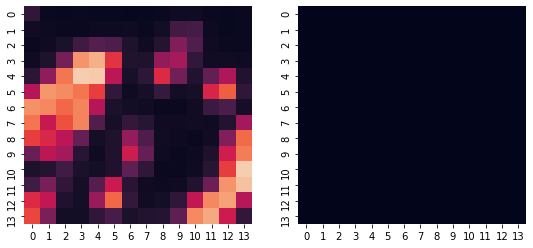

1730 7.295457680855859 42.88718409999998


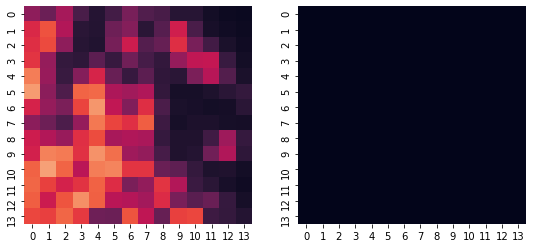

1732 5.359547170893579 42.436972360000034


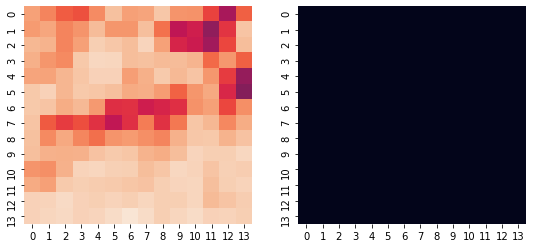

1739 3.693763707926446 39.060384260000056


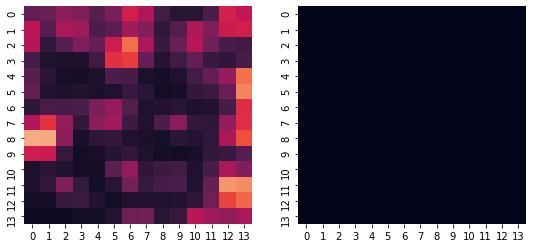

1857 9.610925729811624 -74.21777917000026


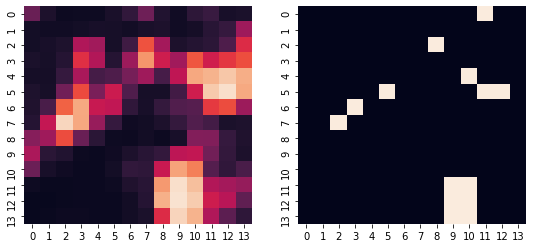

1860 2.450447455951135 -76.60245682000007


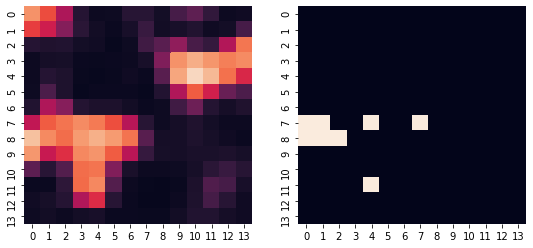

2000 -4.508822927910328 -49.0131911


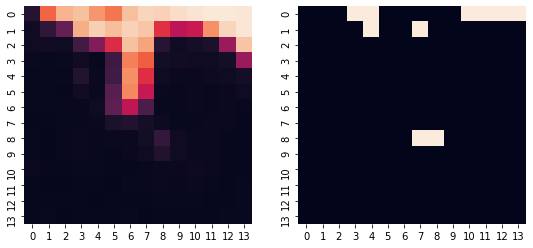

2062 0.4268255089914601 34.88764608000002


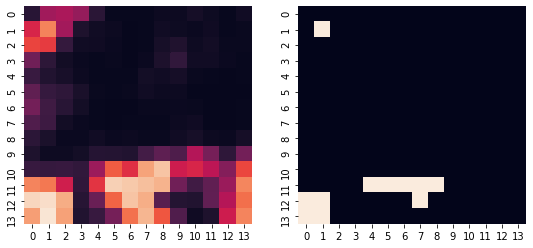

2121 3.088934153938415 43.72636571000002


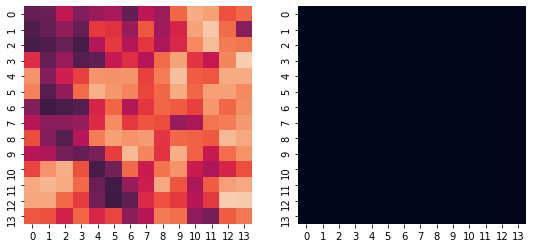

2157 -23.97714411957507 43.99754099999985


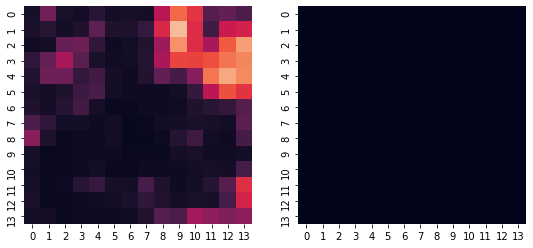

2162 21.84633149960472 -78.2390539899999


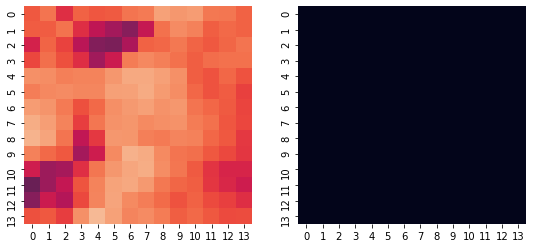

2170 7.5780571648504 -71.13441216999996


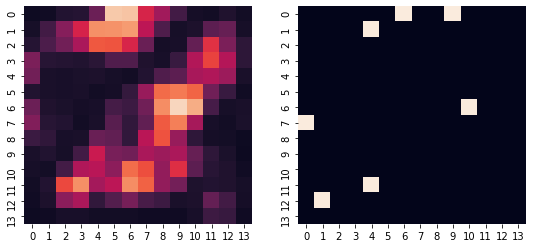

2221 13.117094189747071 -15.608166839999972


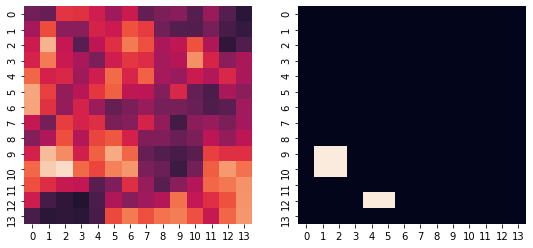

2430 -3.70916502092612 38.58027890999983


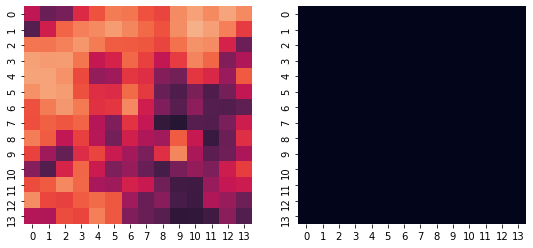

2447 -2.5830762069484914 37.78361309000016


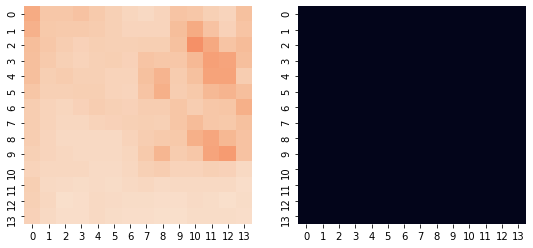

2471 1.8540498669629903 40.49294917000015


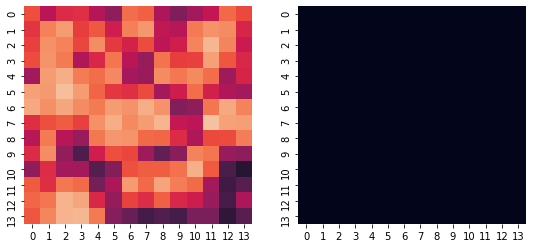

2473 2.0389301199593213 40.27445431999998


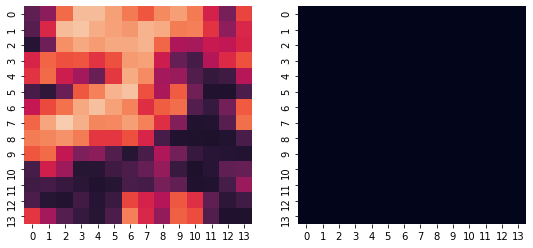

2474 2.243979127955229 40.328237669999886


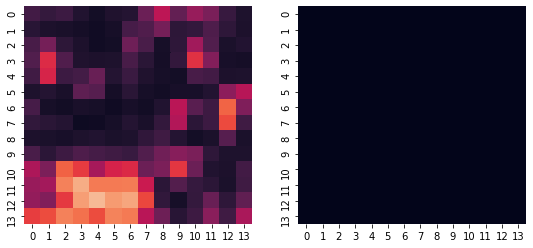

2478 2.6574386029469923 40.48958770999986


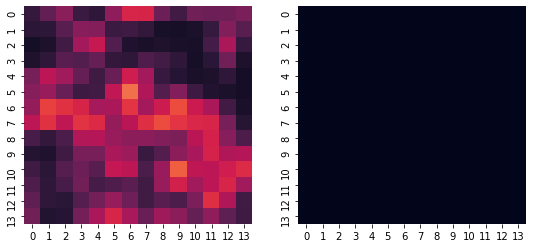

2486 3.6389846739275 40.519840840000015


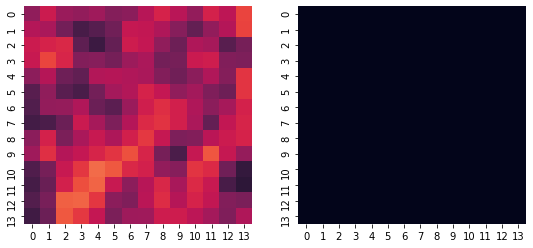

2516 -4.351396433913423 38.9257056599999


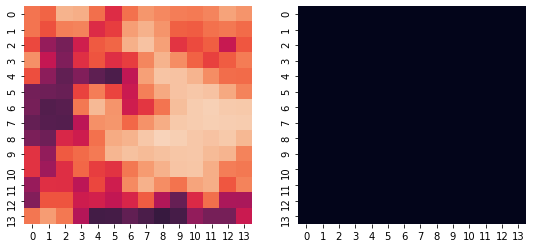

2524 -4.058657749919204 39.04882006


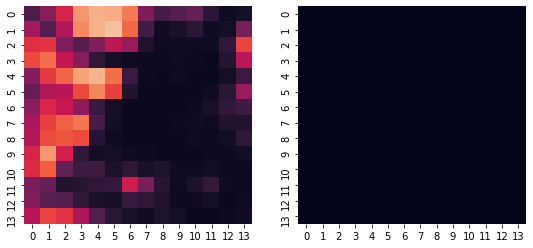

2555 -2.1353372409574014 39.492031900000015


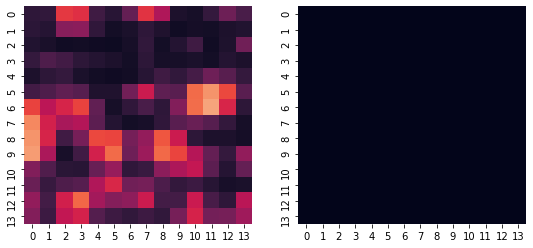

2643 -3.0738137389387306 38.0391943900001


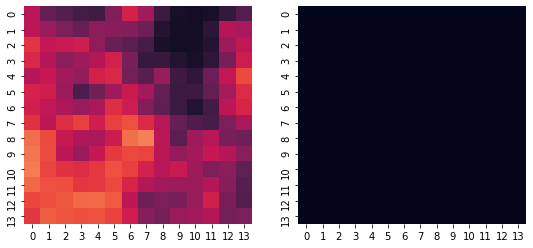

2645 -3.706626421926185 37.83715179000015


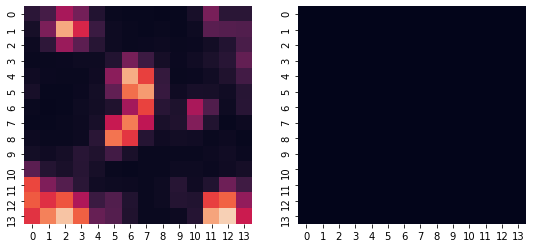

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import skimage.transform
#from skimage.transform import resize
oob = []
idx = 0
for i in range(idx, x.shape[0]):
    #print(idx, df.iloc[idx])
    sample = preprocess_sample(x, idx)
    output_smp = np.zeros((28, 28))
    #sample = skimage.transform.resize(sample, (13, 28*2, 28*2, 17), 1)
    
    batch_x = sample[np.newaxis]
    lengths = np.full((batch_x.shape[0]), 12)
    preds = predict_sess.run(predict_logits,
                          feed_dict={predict_inp:batch_x, 
                                     predict_length:lengths})
    
    
    if np.sum(test_y[idx]) < 20:
        if abs(np.sum(preds > 0.5) - np.sum(test_y[idx])) > 20:
            #print(i, )
            #oob.append(i)
            print(idx, df.iloc[idx]['lat'],  df.iloc[idx]['long'])
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (9, 4))
            sns.heatmap(preds.squeeze(), vmin = 0.0, vmax = 1, ax=ax1, cbar = False)
            sns.heatmap(test_y[idx], vmin = 0.0, vmax = 1, ax=ax2, cbar = False)
            plt.show()
    idx += 1

In [17]:
len(oob)

195

In [18]:
print(oob) 

[189, 244, 255, 268, 282, 307, 328, 343, 366, 378, 380, 383, 384, 385, 386, 388, 389, 390, 397, 407, 441, 443, 444, 447, 451, 452, 469, 471, 474, 476, 481, 503, 504, 527, 548, 580, 582, 591, 607, 622, 737, 832, 844, 851, 876, 879, 888, 889, 892, 898, 921, 922, 946, 978, 1033, 1059, 1063, 1099, 1101, 1105, 1107, 1125, 1167, 1176, 1183, 1206, 1229, 1238, 1242, 1279, 1348, 1355, 1361, 1387, 1397, 1419]


In [12]:
al = 0.33

def make_evaluation_csv(data):
    test_ids = [x for x in range(len(x))]
    print(len(test_ids))
    sums = []
    sum_preds = []
    trues = []
    preds = []
    preds_arr = np.zeros_like(test_y)
    for test_sample in test_ids:
        #x_input = x[test_sample]#.reshape(1, 13, 28, 28, 17)
        x_input = preprocess_sample(x, test_sample)
        batch_x = x_input[np.newaxis]
        lengths = np.full((batch_x.shape[0]), 12)
        y = predict_sess.run(predict_logits,
                              feed_dict={predict_inp:batch_x, 
                                         predict_length:lengths})
        preds.append(y.reshape((14, 14)))
        trues.append(test_y[test_sample].reshape((14, 14)))
        preds_arr[test_sample] = y.reshape((14, 14))
    thresh = 0.4
    tps_relaxed = np.empty((len(preds), ))
    fps_relaxed = np.empty((len(preds), ))
    fns_relaxed = np.empty((len(preds), ))
    abs_error = np.empty((len(preds), ))
    
    tree_cover = []
    for sample in range(len(preds)):
        pred = np.copy(preds[sample])
        true = trues[sample]
        if thresh == 8:
            if np.sum(true + pred) > 0:
                dice_losses.append(0.5)
               # dice_losses.append(dice_loss_tolerance(np.array(true), np.array(pred)))
            else:
                dice_losses.append(1.)
        pred[np.where(pred >= thresh)] = 1
        pred[np.where(pred < thresh)] = 0

        true_s = np.sum(true)
        pred_s = np.sum(pred)
        
        tp_relaxed, fp_relaxed, fn_relaxed = compute_f1_score_at_tolerance(true, pred)
        abs_error[sample] = int((true_s - pred_s) // 1.96)
        print(abs_error[sample])
        tps_relaxed[sample] = tp_relaxed
        fps_relaxed[sample] = fp_relaxed
        fns_relaxed[sample] = fn_relaxed       
        tree_cover.append(int( (np.sum(true) * 100) // 196))

    oa_error = np.mean(abs_error)
    precision_r = np.sum(tps_relaxed) / (np.sum(tps_relaxed) + np.sum(fps_relaxed))
    recall_r = np.sum(tps_relaxed) / (np.sum(tps_relaxed) + np.sum(fns_relaxed))
    f1_r = 2*((precision_r* recall_r) / (precision_r + recall_r))
    data['error'] = abs_error
    data['tp'] = tps_relaxed
    data['fp'] = fps_relaxed
    data['fn'] = fns_relaxed
    data['tree_cover'] = tree_cover
    
    return data, preds_arr

In [13]:
def compute_f1_score_at_tolerance(true, pred, tolerance = 1):
    """Because of coregistration errors, we evaluate the model
    where false positives/negatives must be >1px away from a true positive
    """
    fp = 0
    tp = 0
    fn = 0
    
    tp = np.zeros_like(true)
    fp = np.zeros_like(true)
    fn = np.zeros_like(true)
    
    for x in range(true.shape[0]):
        for y in range(true.shape[1]):
            min_x = np.max([0, x-1])
            min_y = np.max([0, y-1])
            max_y = np.min([true.shape[0], y+2])
            max_x = np.min([true.shape[0], x+2])
            if true[x, y] == 1:
                if np.sum(pred[min_x:max_x, min_y:max_y]) > 0:
                    tp[x, y] = 1
                else:
                    fn[x, y] = 1
            if pred[x, y] == 1:
                if np.sum(true[min_x:max_x, min_y:max_y]) > 0:
                    if true[x, y] == 1:
                        tp[x, y] = 1
                else:
                    fp[x, y] = 1                
                
    return np.sum(tp), np.sum(fp), np.sum(fn)

def calculate_metrics(al = 0.4, canopy_thresh = 100):
    '''Calculates the following metrics
       
         - Loss
         - F1
         - Precision
         - Recall
         - Dice
         - Mean surface distance
         - Average error
    
         Parameters:
          al (float):
          canopy_thresh (int)
          
         Returns:
          val_loss (float):
          best_dice (float):
          error (float):
    '''
    best_f1, best_thresh, relaxed_f1 = 0, 0, 0
    preds, trues, vls = [], [], []

    for test_sample in range(x.shape[0]):
        sample = preprocess_sample(x, test_sample)
        batch_x = sample[np.newaxis]
        lengths = np.full((batch_x.shape[0]), 12)
        y = predict_sess.run(predict_logits,
                              feed_dict={predict_inp:batch_x, 
                                         predict_length:lengths})
        preds.append(y.reshape((14, 14)))
        trues.append(test_y[test_sample].reshape((14, 14)))

    # These threshes are just for ROC
    for thresh in range(7, 9):
        tps_relaxed = np.empty((len(preds), ))
        fps_relaxed = np.empty((len(preds), ))
        fns_relaxed = np.empty((len(preds), ))
        abs_error = np.empty((len(preds), ))
        
        for sample in range(len(preds)):
            pred = np.copy(preds[sample])
            true = trues[sample]
        
            pred[np.where(pred >= thresh*0.05)] = 1
            pred[np.where(pred < thresh*0.05)] = 0
            
            true_s = np.sum(true[1:-1])
            pred_s = np.sum(pred[1:-1])
            abs_error[sample] = abs(true_s - pred_s)
            tp_relaxed, fp_relaxed, fn_relaxed = compute_f1_score_at_tolerance(true, pred)
            tps_relaxed[sample] = tp_relaxed
            fps_relaxed[sample] = fp_relaxed
            fns_relaxed[sample] = fn_relaxed                   
            
        oa_error = np.mean(abs_error)
        precision_r = np.sum(tps_relaxed) / (np.sum(tps_relaxed) + np.sum(fps_relaxed))
        recall_r = np.sum(tps_relaxed) / (np.sum(tps_relaxed) + np.sum(fns_relaxed))
        f1_r = 2*((precision_r* recall_r) / (precision_r + recall_r))
        
        if f1_r > best_f1:
            best_f1 = f1_r
            p = precision_r
            r = recall_r
            error = oa_error
            best_thresh = thresh*0.05

    print(f" Thresh: {np.around(best_thresh, 2)}"
          f" F1: {np.around(best_f1, 3)} R: {np.around(p, 3)} P: {np.around(r, 3)}"
          f" Error: {np.around(error, 3)}")
    return np.mean(vls), best_f1, error, (fps_relaxed + fns_relaxed)

In [14]:
l, preds_arr = make_evaluation_csv(df)

1424
0.0
0.0
9.0
10.0
-29.0
-8.0
2.0
0.0
1.0
0.0
0.0
2.0
0.0
0.0
0.0
0.0
-6.0
7.0
-5.0
-4.0
-7.0
0.0
0.0
-9.0
1.0
0.0
-6.0
0.0
3.0
17.0
-4.0
0.0
-1.0
-9.0
0.0
0.0
1.0
7.0
0.0
-1.0
-8.0
6.0
-18.0
1.0
-1.0
1.0
0.0
1.0
-3.0
-9.0
0.0
-10.0
-2.0
5.0
0.0
-14.0
0.0
0.0
0.0
13.0
0.0
-1.0
12.0
0.0
-1.0
2.0
-3.0
0.0
-10.0
-9.0
0.0
0.0
3.0
0.0
-14.0
-4.0
-5.0
0.0
-13.0
-9.0
-1.0
-1.0
-5.0
1.0
-10.0
0.0
2.0
0.0
0.0
0.0
0.0
-1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
18.0
0.0
0.0
-6.0
0.0
0.0
0.0
0.0
-16.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
11.0
0.0
0.0
6.0
0.0
-21.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-6.0
0.0
0.0
0.0
0.0
-8.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-10.0
0.0
0.0
0.0
7.0
0.0
9.0
-2.0
0.0
0.0
-13.0
2.0
0.0
0.0
0.0
0.0
0.0
0.0
-5.0
-15.0
5.0
0.0
0.0
0.0
0.0
-5.0
0.0
0.0
4.0
0.0
0.0
0.0
5.0
0.0
20.0
-7.0
0.0
0.0
0.0
0.0
-13.0
0.0
-11.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
24.0
0.0
0.0
-27.0
0.0
0.0
0.0
-11.0
0.0
-8.0
-5.0
0.0
-14.0
0.0
0.0
0.0

In [15]:
df = pd.DataFrame(columns = ['scale', 'error', 'Reference tree cover (%)', 'Threshold'])

def check_treecover_accuracy_at_grain(y, pred, scale, mincc, maxcc, threshold):
    y_scale = y[:, 2:2+scale, 2:2+scale]
    pred_scale = pred[:, 2:2+scale, 2:2+scale]
    pred_scale[pred_scale < 0.25] = 0.
    y_scale_mean = np.mean(y_scale, axis = (1, 2))
    if threshold == True:
        pred_scale_mean = np.mean(pred_scale > 0.4, axis = (1, 2))
    else:
        pred_scale_mean = np.mean(pred_scale, axis = (1, 2))
    return abs(y_scale_mean - pred_scale_mean)[np.logical_and(y_scale_mean >= mincc /100, y_scale_mean < maxcc / 100)]

for scale in [2, 3, 4, 5, 6, 7, 8, 9, 10]:
    for mincc in [0, 10, 40]:
        for threshold in [False]:
            if mincc == 0:
                maxcc = 10
            if mincc == 10:
                maxcc = 40
            if mincc == 40:
                maxcc = 100
                
            error1ha = check_treecover_accuracy_at_grain(test_y, preds_arr, scale, mincc, maxcc, threshold)
            if maxcc < 100:
                maxcc = maxcc - 1
            cc_label = f'{str(mincc)}-{str(maxcc)}'
            m = pd.DataFrame({"scale": [scale * 10] * len(error1ha),
                              "error":  error1ha * 100, 
                              'Reference tree cover (%)': [cc_label] * len(error1ha),
                              'Threshold': [threshold] * len(error1ha)})
            print(scale, mincc, threshold, len(error1ha))
            df = df.append(m, ignore_index = True)
print(np.mean(df['error']))

2 0 False 708
2 10 False 72
2 40 False 93
3 0 False 634
3 10 False 156
3 40 False 125
4 0 False 643
4 10 False 145
4 40 False 145
5 0 False 647
5 10 False 142
5 40 False 157
6 0 False 639
6 10 False 153
6 40 False 169
7 0 False 627
7 10 False 171
7 40 False 176
8 0 False 632
8 10 False 167
8 40 False 183
9 0 False 637
9 10 False 159
9 40 False 197
10 0 False 615
10 10 False 174
10 40 False 212
6.573748027848466


In [18]:
df.to_csv("treecover_error_by_scale.csv", index = False)

In [24]:
l = df[df['Reference tree cover (%)'] == '40-100']
l = l[l['scale'] == 70]
np.mean(l)

scale       70.00000
error       15.55529
Threshold    0.00000
dtype: float64

/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/axisgrid.py:648: UserWarning: Using the violinplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 1440x720 with 0 Axes>

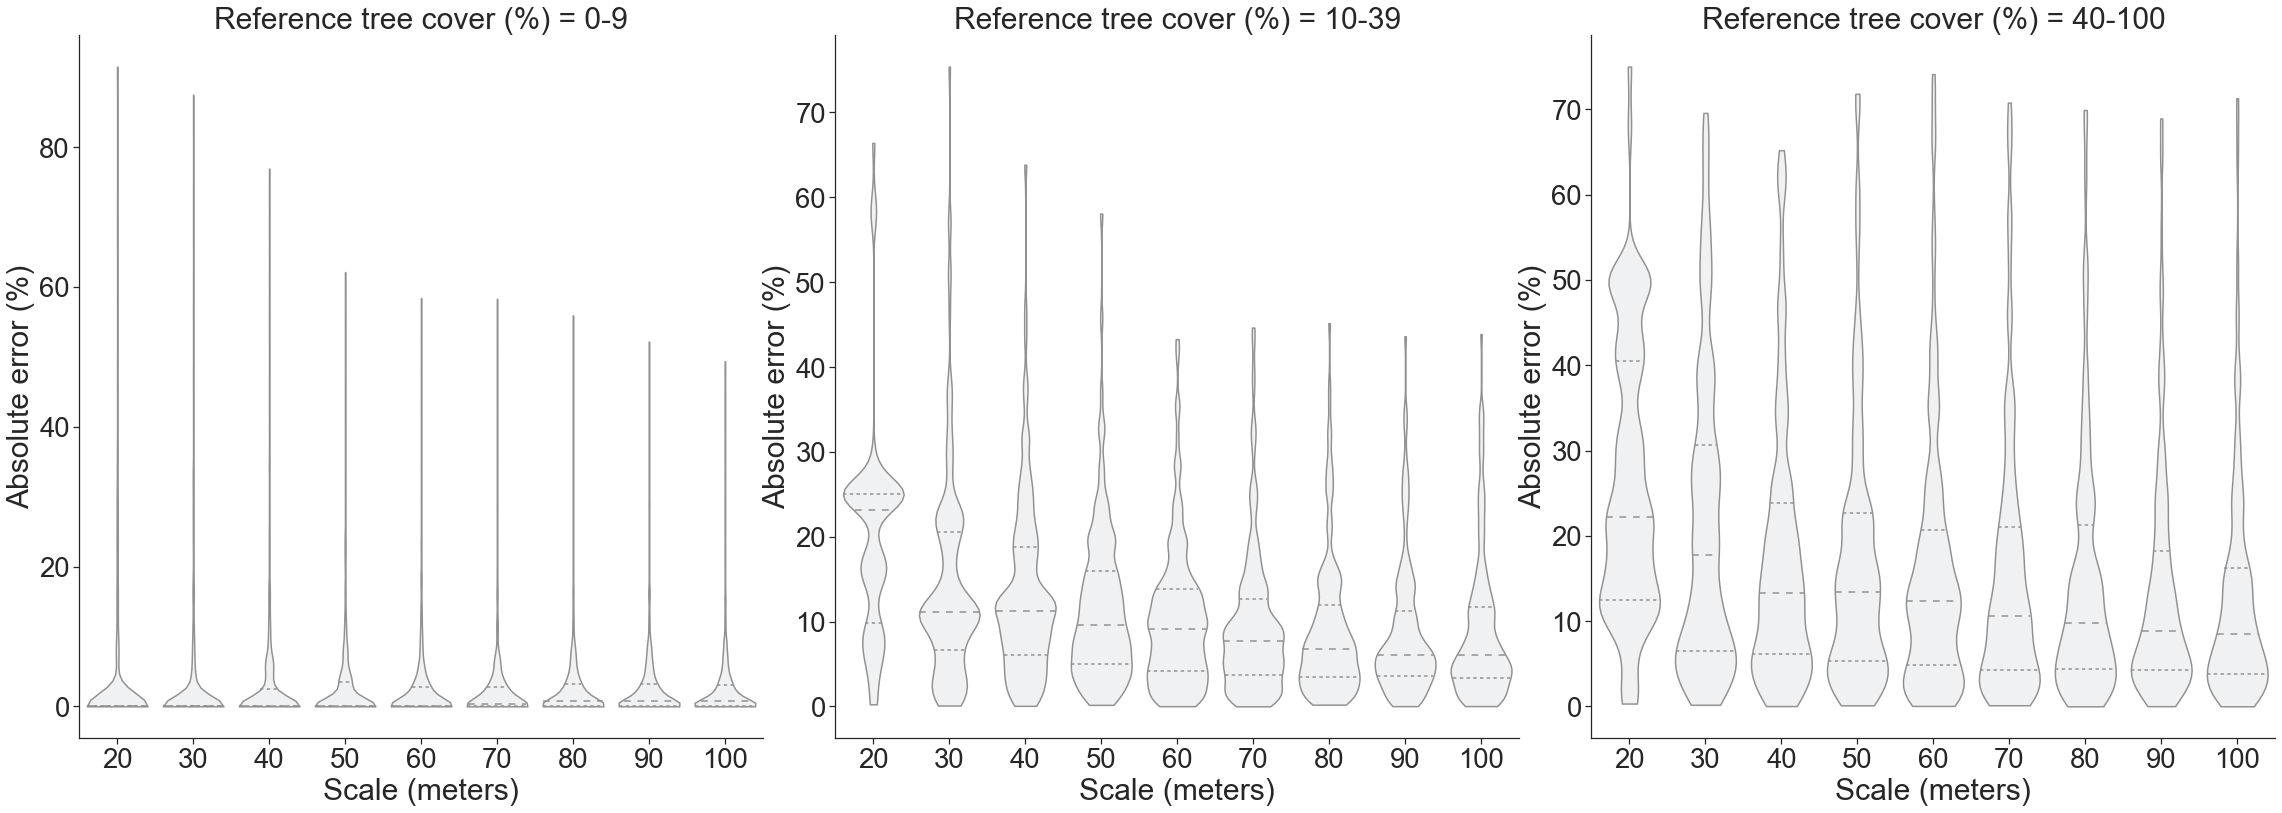

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale = 2.5)
sns.set_style("ticks")
plt.figure(figsize=(20, 10))
facet = sns.FacetGrid(df, col='Reference tree cover (%)', sharey = False, height = 12, aspect = 0.9)
facet.map(sns.violinplot, "scale", "error", 'Threshold', cut = 0, bw = 0.15, inner = 'quartile')
facet.set(xlabel = "Scale (meters)", ylabel = "Absolute error (%)")
#l.set(ylim = (0, 1.))
#plt.savefig("supplementary_figure6.pdf", dpi = 200, bbox_inches = "tight")